In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import alexnet
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# AlexNet con Pytorch
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #RGB y CIFAR-10, Normalizacion
])

#DataTest a vectores
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#Cargamos CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Loss: 2.133
Epoch 2, Loss: 1.714
Epoch 3, Loss: 1.460
Epoch 4, Loss: 1.275
Epoch 5, Loss: 1.118
Epoch 6, Loss: 0.994
Epoch 7, Loss: 0.886
Epoch 8, Loss: 0.816
Epoch 9, Loss: 0.752
Epoch 10, Loss: 0.703
Epoch 11, Loss: 0.659
Epoch 12, Loss: 0.622
Epoch 13, Loss: 0.581
Epoch 14, Loss: 0.550
Epoch 15, Loss: 0.520
Epoch 16, Loss: 0.493
Epoch 17, Loss: 0.470
Epoch 18, Loss: 0.448
Epoch 19, Loss: 0.426
Epoch 20, Loss: 0.402
Epoch 21, Loss: 0.382
Epoch 22, Loss: 0.372
Epoch 23, Loss: 0.358
Epoch 24, Loss: 0.342
Epoch 25, Loss: 0.327
Epoch 26, Loss: 0.319
Epoch 27, Loss: 0.306
Epoch 28, Loss: 0.293
Epoch 29, Loss: 0.282
Epoch 30, Loss: 0.268
Epoch 31, Loss: 0.181
Epoch 32, Loss: 0.155
Epoch 33, Loss: 0.146
Epoch 34, Loss: 0.142
Epoch 35, Loss: 0.134
Epoch 36, Loss: 0.131
Epoch 37, Loss: 0.129
Epoch 38, Loss: 0.124
Epoch 39, Loss: 0.119
Epoch 40, Loss: 0.114
Epoch 41, Loss: 0.114
Epoch 42, Loss: 0.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets

# Define AlexNet en TF/KERAS
def create_alexnet():
    model = models.Sequential([
        layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
        layers.MaxPooling2D((2,2), strides=2),
        layers.Conv2D(192, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((2,2), strides=2),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((2,2), strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

#Cargamos el CIFAR-10
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
#Normalizamos en base a RGB y CIFAR-10
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Training
model = create_alexnet()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Training
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                   epochs=50,
                   validation_data=(x_test, y_test))


test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc*100:.2f}%')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - accuracy: 0.2686 - loss: 1.9689 - val_accuracy: 0.5316 - val_loss: 1.2952
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - accuracy: 0.5188 - loss: 1.3148 - val_accuracy: 0.6429 - val_loss: 1.0038
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.6153 - loss: 1.0733 - val_accuracy: 0.6893 - val_loss: 0.9062
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.6799 - loss: 0.9079 - val_accuracy: 0.7176 - val_loss: 0.8274
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.7220 - loss: 0.7842 - val_accuracy: 0.7613 - val_loss: 0.6839
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.7525 - loss: 0.7062 - val_accuracy: 0.7726 - val_loss: 0.6649
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.7811 - loss: 0.6346 - val_accuracy: 0.7865 - val_loss: 0.6281
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.7950 - loss: 0.5901 -

In [ ]:
# AlexNet preentrenado para CIFAR-10
class PretrainedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(PretrainedAlexNet, self).__init__()
        # Cargar modelo preentrenado
        model = alexnet(pretrained=True)

        # Usar featuresdel modelo preentrenado
        self.features = model.features

        # Usar avgpool como en el modelo original
        self.avgpool = model.avgpool

        # Adaptación del clasificador
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
#En tensorflow no existe el pre entrenado de AlexNet entonce usamos VGG16 solamente para llenar
#el espacio, pero en realidad esperamos que performee de peor manera de los 4.
def create_pretrained_vgg():

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    for layer in base_model.layers:
        layer.trainable = False


    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model


In [ ]:
def train_evaluate_pytorch(model_name, model, trainloader, testloader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Para almacenar métricas
    train_losses = []
    train_accs = []
    test_accs = []
    times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss/len(trainloader)
        train_acc = 100 * correct / total

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_acc = 100 * test_correct / test_total

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'[{model_name}] Epoch {epoch+1}/{num_epochs}, '
              f'Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, '
              f'Test Acc: {test_acc:.2f}%, Time: {epoch_time:.2f}s')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'times': times,
        'final_test_acc': test_accs[-1],
        'total_time': sum(times)
    }


In [ ]:
# Función de entrenamiento para TensorFlow
def train_evaluate_tensorflow(model_name, model, x_train, y_train, x_test, y_test, datagen, num_epochs=10):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Para almacenar metricas
    train_losses = []
    train_accs = []
    test_accs = []
    times = []

    # Definir callbacks para registrar metricas
    class TimeHistory(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs={}):
            self.epoch_start_time = time.time()

        def on_epoch_end(self, epoch, logs={}):
            epoch_time = time.time() - self.epoch_start_time
            times.append(epoch_time)

            # Evaluar en conjunto de prueba
            test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
            test_accs.append(test_acc * 100)

            # Registrar metricas de entrenamiento
            train_losses.append(logs.get('loss'))
            train_accs.append(logs.get('accuracy') * 100)

            print(f'[{model_name}] Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {logs.get("loss"):.3f}, Train Acc: {logs.get("accuracy")*100:.2f}%, '
                  f'Test Acc: {test_acc*100:.2f}%, Time: {epoch_time:.2f}s')

    time_callback = TimeHistory()

    # Entrenar modelo
    model.fit(
        datagen.flow(x_train, y_train, batch_size=128),
        epochs=num_epochs,
        verbose=0,
        callbacks=[time_callback]
    )

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'times': times,
        'final_test_acc': test_accs[-1],
        'total_time': sum(times)
    }


In [ ]:
def run_comparison(num_epochs=10):
    # Para modelo from scratch
    transform_train_scratch = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test_scratch = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Para modelo preentrenado
    transform_train_pretrained = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Media  desviación de ImageNet
    ])

    transform_test_pretrained = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Media  desviación de ImageNet
    ])

    # Cargar datos
    print("Cargando datos para PyTorch...")
    trainset_scratch = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_scratch)
    trainloader_scratch = torch.utils.data.DataLoader(trainset_scratch, batch_size=128, shuffle=True, num_workers=2)

    testset_scratch = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_scratch)
    testloader_scratch = torch.utils.data.DataLoader(testset_scratch, batch_size=128, shuffle=False, num_workers=2)

    trainset_pretrained = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_pretrained)
    trainloader_pretrained = torch.utils.data.DataLoader(trainset_pretrained, batch_size=64, shuffle=True, num_workers=2)

    testset_pretrained = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_pretrained)
    testloader_pretrained = torch.utils.data.DataLoader(testset_pretrained, batch_size=64, shuffle=False, num_workers=2)

    # TensorFlow Data Loading
    print("Cargando datos para TensorFlow...")
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # Normalización
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # Data Augmentation para TensorFlow
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    datagen.fit(x_train)

    # Resultados
    results = {}

    try:
        # PyTorch from scratch
        print("\nEntrenando AlexNet desde cero con PyTorch...")
        model_scratch_pt = AlexNet()
        results['pytorch_scratch'] = train_evaluate_pytorch(
            'PyTorch Scratch', model_scratch_pt, trainloader_scratch, testloader_scratch, num_epochs)
    except Exception as e:
        print(f"Error con PyTorch desde cero: {e}")
        results['pytorch_scratch'] = {
            'train_losses': [0] * num_epochs,
            'train_accs': [0] * num_epochs,
            'test_accs': [0] * num_epochs,
            'times': [0] * num_epochs,
            'final_test_acc': 0,
            'total_time': 0
        }

    try:
        # PyTorch  pre entrenado
        print("\nEntrenando AlexNet preentrenado con PyTorch...")
        model_pretrained_pt = PretrainedAlexNet()
        results['pytorch_pretrained'] = train_evaluate_pytorch(
            'PyTorch Pretrained', model_pretrained_pt, trainloader_pretrained, testloader_pretrained, num_epochs)
    except Exception as e:
        print(f"Error con PyTorch preentrenado: {e}")
        results['pytorch_pretrained'] = {
            'train_losses': [0] * num_epochs,
            'train_accs': [0] * num_epochs,
            'test_accs': [0] * num_epochs,
            'times': [0] * num_epochs,
            'final_test_acc': 0,
            'total_time': 0
        }

    try:
        # TensorFlow from scratch
        print("\nEntrenando AlexNet desde cero con TensorFlow...")
        model_scratch_tf = create_alexnet()
        results['tensorflow_scratch'] = train_evaluate_tensorflow(
            'TensorFlow Scratch', model_scratch_tf, x_train, y_train, x_test, y_test, datagen, num_epochs)
    except Exception as e:
        print(f"Error con TensorFlow desde cero: {e}")
        results['tensorflow_scratch'] = {
            'train_losses': [0] * num_epochs,
            'train_accs': [0] * num_epochs,
            'test_accs': [0] * num_epochs,
            'times': [0] * num_epochs,
            'final_test_acc': 0,
            'total_time': 0
        }

    try:
        # TensorFlow pre entrenado
        print("\nEntrenando AlexNet preentrenado con TensorFlow...")
        model_pretrained_tf = create_pretrained_vgg()
        results['tensorflow_pretrained'] = train_evaluate_tensorflow(
            'TensorFlow Pretrained', model_pretrained_tf, x_train, y_train, x_test, y_test, datagen, num_epochs)
    except Exception as e:
        print(f"Error con TensorFlow preentrenado: {e}")
        results['tensorflow_pretrained'] = {
            'train_losses': [0] * num_epochs,
            'train_accs': [0] * num_epochs,
            'test_accs': [0] * num_epochs,
            'times': [0] * num_epochs,
            'final_test_acc': 0,
            'total_time': 0
        }

    return results

Cargando datos para PyTorch...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Cargando datos para TensorFlow...

Entrenando AlexNet desde cero con PyTorch...
Usando dispositivo: cuda
[PyTorch Scratch] Epoch 1/10, Loss: 2.162, Train Acc: 17.77%, Test Acc: 31.88%, Time: 23.21s
[PyTorch Scratch] Epoch 2/10, Loss: 1.750, Train Acc: 34.00%, Test Acc: 43.51%, Time: 24.12s
[PyTorch Scratch] Epoch 3/10, Loss: 1.492, Train Acc: 44.32%, Test Acc: 50.33%, Time: 24.24s
[PyTorch Scratch] Epoch 4/10, Loss: 1.307, Train Acc: 51.55%, Test Acc: 59.43%, Time: 24.29s
[PyTorch Scratch] Epoch 5/10, Loss: 1.154, Train Acc: 57.95%, Test Acc: 63.19%, Time: 24.44s
[PyTorch Scratch] Epoch 6/10, Loss: 0.963, Train Acc: 65.13%, Test Acc: 66.90%, Time: 24.27s
[PyTorch Scratch] Epoch 7/10, Loss: 0.925, Train Acc: 66.50%, Test Acc: 68.13%, Time: 25.21s
[PyTorch Scratch] Epoch 8/10, Loss: 0.893, Train Acc: 67.51%,

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 172MB/s]


Usando dispositivo: cuda
[PyTorch Pretrained] Epoch 1/10, Loss: 0.964, Train Acc: 66.32%, Test Acc: 78.78%, Time: 123.25s
[PyTorch Pretrained] Epoch 2/10, Loss: 0.629, Train Acc: 78.59%, Test Acc: 81.32%, Time: 124.79s
[PyTorch Pretrained] Epoch 3/10, Loss: 0.541, Train Acc: 81.49%, Test Acc: 83.59%, Time: 125.66s
[PyTorch Pretrained] Epoch 4/10, Loss: 0.471, Train Acc: 83.94%, Test Acc: 84.76%, Time: 124.63s
[PyTorch Pretrained] Epoch 5/10, Loss: 0.426, Train Acc: 85.47%, Test Acc: 85.08%, Time: 124.81s
[PyTorch Pretrained] Epoch 6/10, Loss: 0.243, Train Acc: 91.80%, Test Acc: 89.61%, Time: 125.81s
[PyTorch Pretrained] Epoch 7/10, Loss: 0.202, Train Acc: 93.07%, Test Acc: 89.90%, Time: 123.82s
[PyTorch Pretrained] Epoch 8/10, Loss: 0.182, Train Acc: 93.76%, Test Acc: 90.23%, Time: 125.97s
[PyTorch Pretrained] Epoch 9/10, Loss: 0.163, Train Acc: 94.23%, Test Acc: 90.17%, Time: 123.87s
[PyTorch Pretrained] Epoch 10/10, Loss: 0.153, Train Acc: 94.80%, Test Acc: 90.26%, Time: 126.85s

Ent

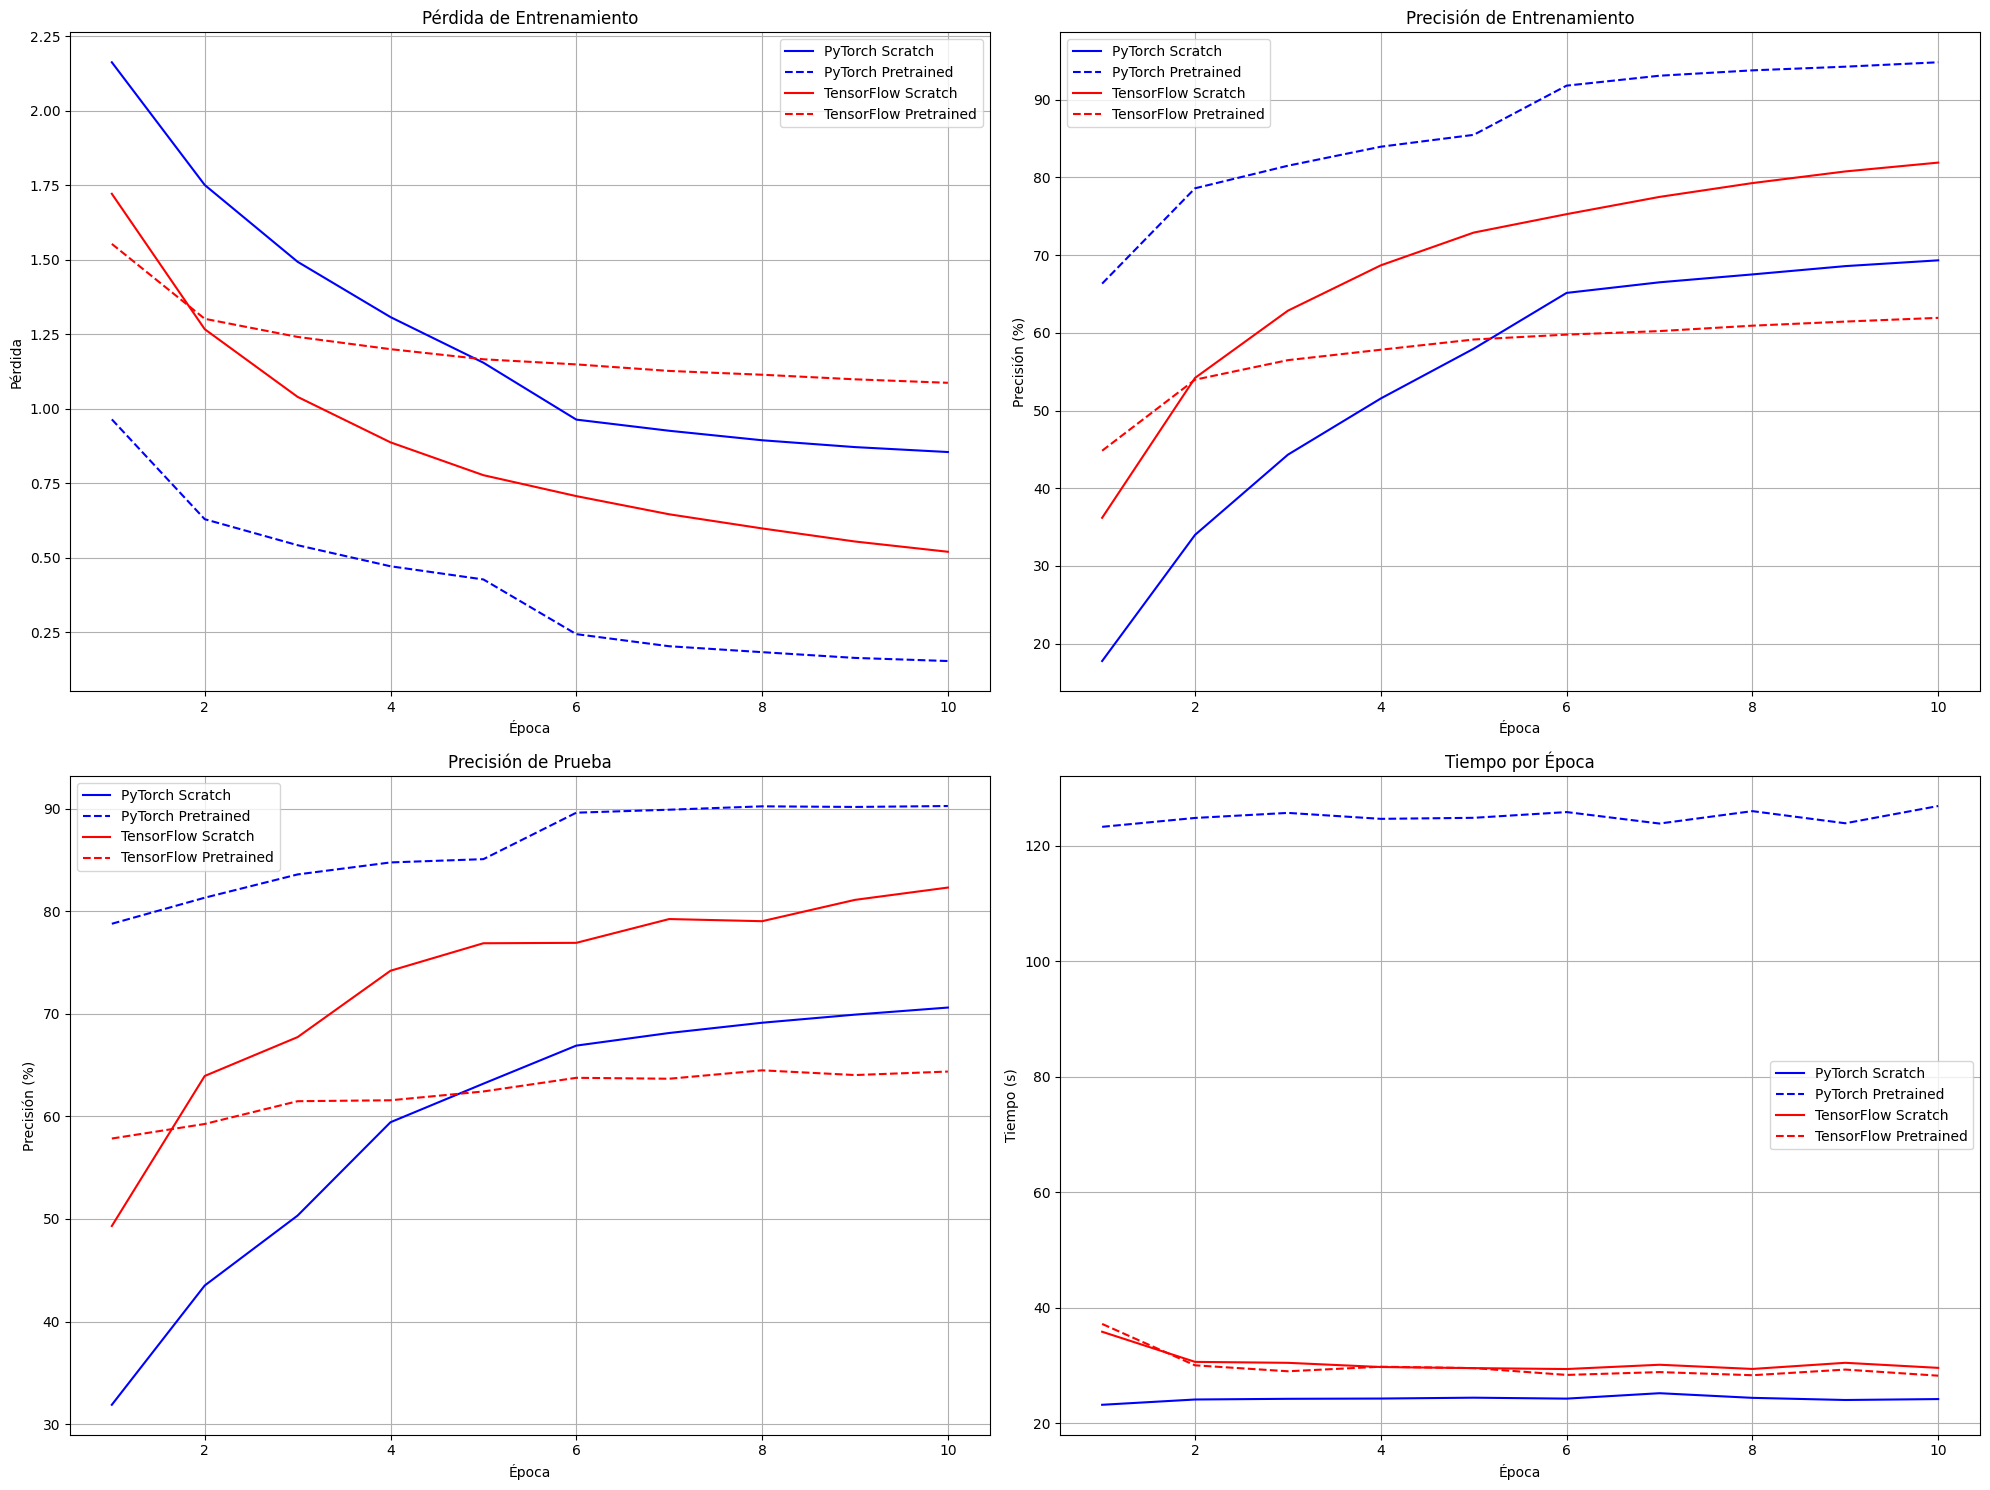

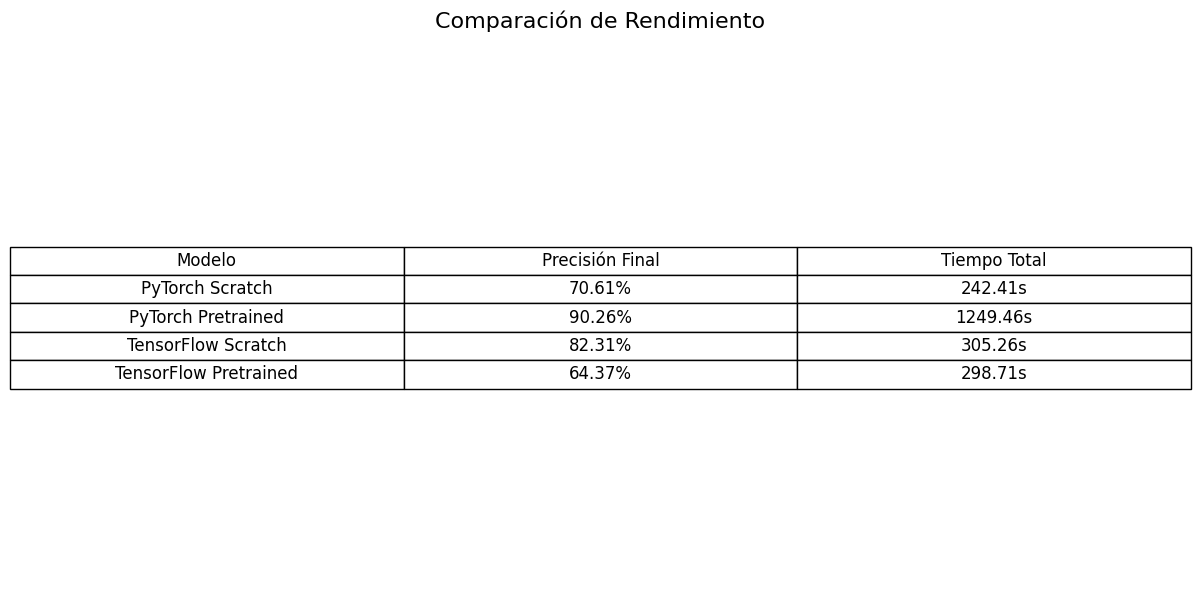

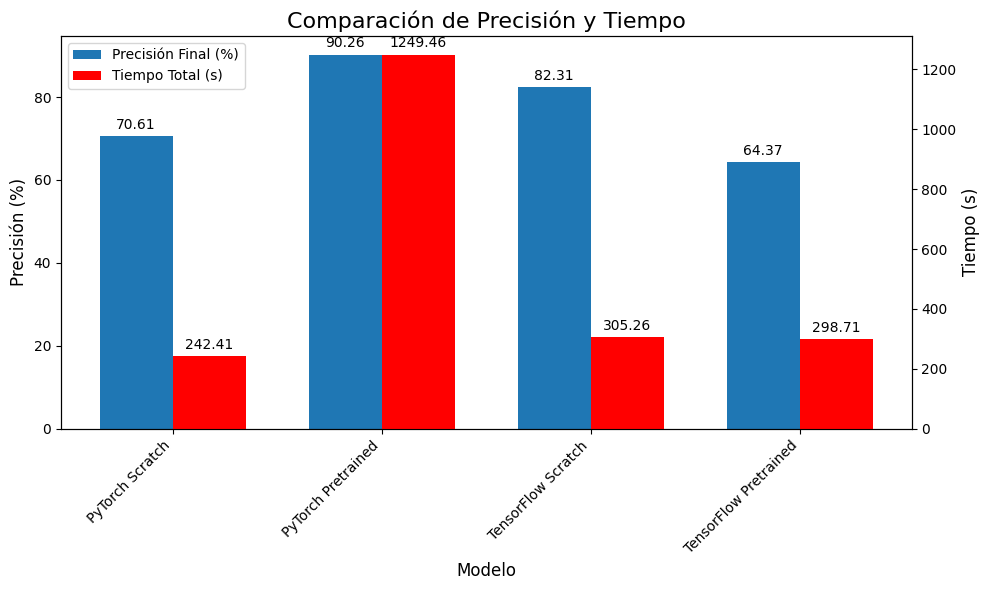

In [ ]:
# Función para visualizar resultados
def plot_results(results, num_epochs):
    # Crear figura con múltiples subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    # Gráfica 1: Pérdida de entrenamiento
    axs[0, 0].plot(range(1, num_epochs+1), results['pytorch_scratch']['train_losses'], 'b-', label='PyTorch Scratch')
    axs[0, 0].plot(range(1, num_epochs+1), results['pytorch_pretrained']['train_losses'], 'b--', label='PyTorch Pretrained')
    axs[0, 0].plot(range(1, num_epochs+1), results['tensorflow_scratch']['train_losses'], 'r-', label='TensorFlow Scratch')
    axs[0, 0].plot(range(1, num_epochs+1), results['tensorflow_pretrained']['train_losses'], 'r--', label='TensorFlow Pretrained')
    axs[0, 0].set_title('Pérdida de Entrenamiento')
    axs[0, 0].set_xlabel('Época')
    axs[0, 0].set_ylabel('Pérdida')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Gráfica 2: Precisión de entrenamiento
    axs[0, 1].plot(range(1, num_epochs+1), results['pytorch_scratch']['train_accs'], 'b-', label='PyTorch Scratch')
    axs[0, 1].plot(range(1, num_epochs+1), results['pytorch_pretrained']['train_accs'], 'b--', label='PyTorch Pretrained')
    axs[0, 1].plot(range(1, num_epochs+1), results['tensorflow_scratch']['train_accs'], 'r-', label='TensorFlow Scratch')
    axs[0, 1].plot(range(1, num_epochs+1), results['tensorflow_pretrained']['train_accs'], 'r--', label='TensorFlow Pretrained')
    axs[0, 1].set_title('Precisión de Entrenamiento')
    axs[0, 1].set_xlabel('Época')
    axs[0, 1].set_ylabel('Precisión (%)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Gráfica 3: Precisión de prueba
    axs[1, 0].plot(range(1, num_epochs+1), results['pytorch_scratch']['test_accs'], 'b-', label='PyTorch Scratch')
    axs[1, 0].plot(range(1, num_epochs+1), results['pytorch_pretrained']['test_accs'], 'b--', label='PyTorch Pretrained')
    axs[1, 0].plot(range(1, num_epochs+1), results['tensorflow_scratch']['test_accs'], 'r-', label='TensorFlow Scratch')
    axs[1, 0].plot(range(1, num_epochs+1), results['tensorflow_pretrained']['test_accs'], 'r--', label='TensorFlow Pretrained')
    axs[1, 0].set_title('Precisión de Prueba')
    axs[1, 0].set_xlabel('Época')
    axs[1, 0].set_ylabel('Precisión (%)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Gráfica 4: Tiempo por época
    axs[1, 1].plot(range(1, num_epochs+1), results['pytorch_scratch']['times'], 'b-', label='PyTorch Scratch')
    axs[1, 1].plot(range(1, num_epochs+1), results['pytorch_pretrained']['times'], 'b--', label='PyTorch Pretrained')
    axs[1, 1].plot(range(1, num_epochs+1), results['tensorflow_scratch']['times'], 'r-', label='TensorFlow Scratch')
    axs[1, 1].plot(range(1, num_epochs+1), results['tensorflow_pretrained']['times'], 'r--', label='TensorFlow Pretrained')
    axs[1, 1].set_title('Tiempo por Época')
    axs[1, 1].set_xlabel('Época')
    axs[1, 1].set_ylabel('Tiempo (s)')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


    models = ['PyTorch Scratch', 'PyTorch Pretrained', 'TensorFlow Scratch', 'TensorFlow Pretrained']
    final_accs = [
        results['pytorch_scratch']['final_test_acc'],
        results['pytorch_pretrained']['final_test_acc'],
        results['tensorflow_scratch']['final_test_acc'],
        results['tensorflow_pretrained']['final_test_acc']
    ]
    total_times = [
        results['pytorch_scratch']['total_time'],
        results['pytorch_pretrained']['total_time'],
        results['tensorflow_scratch']['total_time'],
        results['tensorflow_pretrained']['total_time']
    ]


    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(
        cellText=[
            [models[i], f"{final_accs[i]:.2f}%", f"{total_times[i]:.2f}s"]
            for i in range(len(models))
        ],
        colLabels=['Modelo', 'Precisión Final', 'Tiempo Total'],
        loc='center',
        cellLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)

    plt.title('Comparación de Rendimiento', pad=20, fontsize=16)
    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(models))


    bars1 = ax.bar(index, final_accs, bar_width, label='Precisión Final (%)')


    ax2 = ax.twinx()
    bars2 = ax2.bar(index + bar_width, total_times, bar_width, color='r', label='Tiempo Total (s)')


    ax.set_xlabel('Modelo', fontsize=12)
    ax.set_ylabel('Precisión (%)', fontsize=12)
    ax2.set_ylabel('Tiempo (s)', fontsize=12)
    ax.set_title('Comparación de Precisión y Tiempo', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)


    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bars1, ax)
    autolabel(bars2, ax2)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    NUM_EPOCHS = 10
    results = run_comparison(NUM_EPOCHS)
    plot_results(results, NUM_EPOCHS)